# CAPSNET Monitor

In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')


In [2]:
HTML(
'''<style>
.output_wrapper button.btn.btn-default,
.output_wrapper .ui-dialog-titlebar {
  display: none;
}
</style>''')


In [3]:
%matplotlib notebook

import os
#os.chdir('/home/jens/eclipse-workspace/MatrixCaps/Matrix-Capsule-Network/')

import sys
import pyrr
sys.path.append('../model')
sys.path.append('..')

import torch
from torch.autograd import Variable
from torchvision import datasets
from torchvision import transforms
from torchvision import utils
import torch.nn.functional as F
import capsules as mcaps
import util
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import time
import pyrr

import ipywidgets as widgets
from ipywidgets import FloatSlider, HBox, VBox, Layout
matplotlib.pyplot.ioff()

import glob
from IPython.display import display, Markdown, Image

import PIL.Image
from io import BytesIO


## Matrix Capsules LOSS plot

<IPython.core.display.Javascript object>


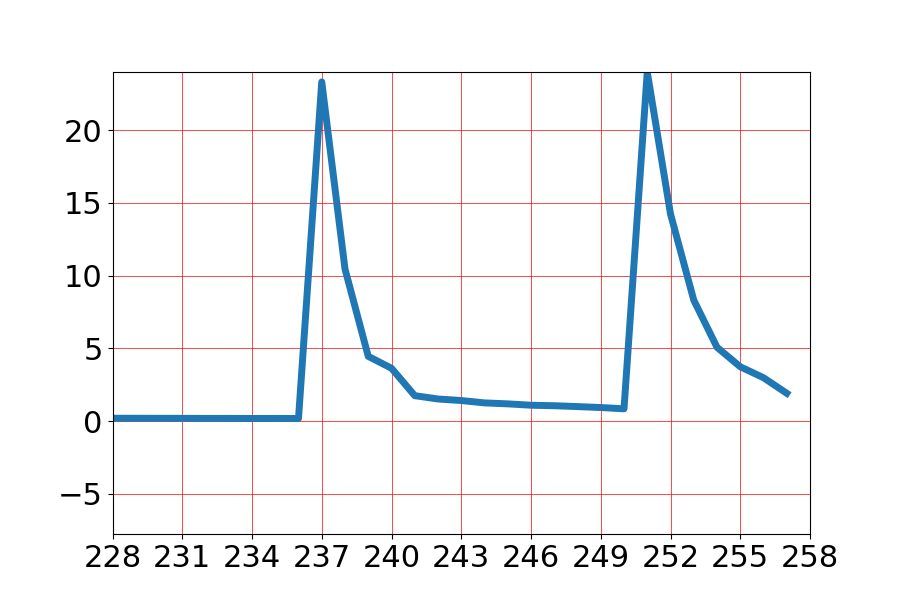

Button(description='Update', style=ButtonStyle())

IntText(value=30, description='Epoch history')

In [4]:
matplotlib.rcParams.update({'font.size': 22})
fig3 = plt.figure(figsize = (9,6))
ax3 = fig3.subplots()
#matplotlib.pyplot.ion()


button = widgets.Button(description="Update")
show_epochs = widgets.IntText(description='Epoch history',disabled=False)
show_epochs.value = 30

def on_button_clicked(b):
    with open('../loss.log') as f:
        content = f.readlines()
    content = [float(x.strip()) for x in content]
    xmin = 0
    xmax = len(content)
    if xmax > show_epochs.value:
        xmin = xmax-show_epochs.value
        content = content[xmin:xmax]
    ymin = np.min(content)
    ymax = np.max(content)
    x_axis = np.linspace(xmin, xmax-1, num=xmax-xmin)

    #matplotlib.pyplot.gcf().clear()
    ax3.clear()
    ax3.set_xlim(xmin, xmax)
    yaxismin = ymin - (ymax-ymin)/3
    if yaxismin < 0:
        yaxismin = 0
    ax3.set_ylim(ymin - (ymax-ymin)/3, ymax)
    ax3.plot(x_axis, content, linewidth=5.0)
    ax3.xaxis.set_major_locator(matplotlib.ticker.MaxNLocator(integer=True))
    ax3.grid(linestyle='-', linewidth='0.5', color='red')
    fig3.canvas.draw()

    
on_button_clicked(None)
fig3.show()

display(button)
display(show_epochs)

button.on_click(on_button_clicked)
show_epochs.observe(on_button_clicked)

In [5]:
class args():
    num_classes = 1
    batch_size = 1
    routing = 'EM_routing'
    loss = 'spread_loss̈́'
    use_recon = 0.001
    r = 3
    num_workers = 1
    disable_encoder = False
    disable_recon = False

A, AA, B, C, D, E, r = 32, 64, 16, 16, 16, args.num_classes, args.r # a small CapsNet

model = mcaps.CapsNet(args, A, AA, B, C, D, E, r, h=4)

LatestFile = max(glob.iglob("../weights/em_capsules/model*.pth"),key=os.path.getctime)

display(Markdown('## Latest model is: '+LatestFile))

model.load_state_dict(torch.load(LatestFile))
model.cpu()

self = model

## Latest model is: ../weights/em_capsules/model_0.pth

## Ground Truth

In [6]:
def updateOutputWidget(widget, array, color="L"):
    f = BytesIO()
    PIL.Image.fromarray(np.uint8(array*255), mode=color).convert(color).save(f, 'png')
    widget.clear_output()
    with widget:
        display(Image(data=f.getvalue(), width='100%'))

ground_truth_widget_left = widgets.Output(layout=Layout(border='1px solid black', width='100%'))
ground_truth_widget_right = widgets.Output(layout=Layout(border='1px solid black', width='100%'))
ground_truth_widget = HBox([ground_truth_widget_left, ground_truth_widget_right], layout=Layout(width='100%'))

contrast_left = widgets.FloatText(layout={'width': '100%'},description='Contrast',disabled=False, value=1, step=0.01)
contrast_right = widgets.FloatText(layout={'width': '100%'},description='Contrast',disabled=False, value=1, step=0.01)
brightness_left = widgets.FloatText(layout={'width': '100%'},description='Brightness',disabled=False, value=0, step=0.01)
brightness_right = widgets.FloatText(layout={'width': '100%'},description='Brightness',disabled=False, value=0, step=0.01)
brightness_contrast_widget = VBox([  HBox([contrast_left, contrast_right],layout=Layout(width='100%')) ,  HBox([brightness_left, brightness_right],layout=Layout(width='100%')) ] )

display(ground_truth_widget)
display(brightness_contrast_widget)

## Activations of convolutional layers and primary capsules layer

In [7]:
layer1_widget = widgets.Output(layout=Layout(width='100%'))
layer2_widget = widgets.Output(layout=Layout(width='100%'))
layer3_widget = widgets.Output(layout=Layout(width='100%'))
layer4_widget = widgets.Output(layout=Layout(width='100%'))
#layer12_widget = HBox([layer1_widget, layer2_widget], layout=Layout(width='100%'))
layer_widget = VBox([layer1_widget, layer2_widget, layer3_widget, layer4_widget], layout=Layout(width='100%'))
display(layer_widget)



def makeCombinedImage(img):
    img = img.squeeze().unsqueeze(1)
    return utils.make_grid(img.data, nrow=int(img.shape[0] ** 0.5), normalize=True,range=(0, 1)).cpu().numpy()
    
def forward(self, x, lambda_, labels=None, draw=True):
    if x is not None:
        x = F.relu(self.bn1(self.conv1(x)))

        if draw is True:
            grid_picture = makeCombinedImage(x)
            updateOutputWidget(layer1_widget, grid_picture.transpose(1,2,0), "RGB")

        #x = F.max_pool2d(x, 2, 2, 1)
        x = F.relu(self.bn2(self.conv2(x)))
        
        if draw is True:
            grid_picture = makeCombinedImage(x)
            updateOutputWidget(layer2_widget, grid_picture.transpose(1,2,0), "RGB")
        
        x = F.relu(self.bn3(self.conv3(x)))
        if draw is True:
            grid_picture = makeCombinedImage(x)
            updateOutputWidget(layer3_widget, grid_picture.transpose(1,2,0), "RGB")
        
        x = self.primary_caps(x)  # b,32*(4*4+1),12,12

        if draw is True:
            grid_picture = makeCombinedImage(x[0])
            updateOutputWidget(layer4_widget, grid_picture.transpose(1,2,0), "RGB")
            
        x = self.convcaps1(x, lambda_)  # b,32*(4*4+1),5,5
        x = self.convcaps2(x, lambda_)  # b,32*(4*4+1),3,3
        p, a = self.classcaps(x, lambda_)  # b,10*16+10

        p = p.squeeze()

        # Temporary when batch size = 1
        if len(p.shape) == 1:
            p = p.unsqueeze(0)
    else:
        p = labels

    if not self.args.disable_recon:
        reconstructions = self.decoder(p)
    else:
        reconstructions = 0

    return p, reconstructions

## 4x4 pose output

In [8]:
truth_widget_left = widgets.Output(layout=Layout(width='100%'))
truth_widget_right = widgets.Output(layout=Layout(width='100%'))
recon_widget_left = widgets.Output(layout=Layout(width='100%'))
recon_widget_right = widgets.Output(layout=Layout(width='100%'))
truth_widget = HBox([truth_widget_left, truth_widget_right], layout=Layout(width='100%'))
recon_widget = HBox([recon_widget_left, recon_widget_right], layout=Layout(width='100%'))
step_widget = VBox([truth_widget, recon_widget], layout=Layout(width='100%'))
names = ['p0', 'p1', 'p2', 'p3', 'p4', 'p5', 'p6', 'p7', 'p8', 'p9', 'p10', 'p11', 'p12', 'p13', 'p14', 'p15']
pose_sliders = [FloatSlider(min=-100, max=100, layout={'height': '50%'}, step=0.00001, description=i, orientation='horizontal') for i in names]
button_next = widgets.Button(description="Next", layout={'height': '50%'})
pose_sliders.append(button_next)
sliders_widget = VBox(pose_sliders, layout=Layout(width='60%'))
step_slider_widget = HBox([step_widget, sliders_widget],layout=Layout(width='100%'))
pose_output = widgets.Text(layout={'width': '100%'},description='Pose output',disabled=False)
pose_label = widgets.Text(layout={'width': '100%'},description='Pose label',disabled=False)
the_time = time.time()
do_update = True

display(step_slider_widget)
display(pose_output)
display(pose_label)

# Initialize Transform Network (from Pose to Quaternion)
"""
import sys
import pyrr
sys.path.append('../PoseToQuaternionNetwork/model')
from transform import PoseToQuatNet
transform = PoseToQuatNet()
transform.load_state_dict(torch.load('../PoseToQuaternionNetwork/weights/model.pth'))
transform.cpu()
"""

# Initialize view and projection for coord system rendering
w_width, w_height = 800, 800
focus_distance = 1.9
view = pyrr.matrix44.create_from_translation(pyrr.Vector3([0.0, 0.0, -focus_distance])).transpose()
projection = pyrr.matrix44.create_perspective_projection_matrix(65.0, w_width / w_height, 0.1, 100.0).transpose()

def plotPoint(pnt, color_idx, img_left, img_right):
    model_view = pyrr.matrix44.multiply(view, pnt)
    model_projection = pyrr.matrix44.multiply(projection, model_view)
    scaling = model_projection[3]
    pix_x = img_left.shape[0]/2 + (model_projection[0]/scaling) * img_left.shape[0]/2
    if pix_x >= img_left.shape[0]: pix_x = img_left.shape[0]-1
    if pix_x < 0: pix_x = 0
    pix_y = img_left.shape[1]/2 - (model_projection[1]/scaling) * img_left.shape[1]/2
    if pix_y >= img_left.shape[1]: pix_y = img_left.shape[1]-1
    if pix_y < 0: pix_y = 0
    img_left[int(pix_y),int(pix_x),color_idx] = 1.0
    img_right[int(pix_y),int(pix_x),color_idx] = 1.0

def plotCoordSystemAxis(pose44, axis_idx, img_left, img_right):
    pnt = pyrr.vector4.create(0.0, 0.0, 0.0, 1.0)
    for i in range(50):
        pnt[axis_idx] = i*0.01
        point = pyrr.matrix44.multiply(pyrr.Matrix44(pose44), pnt) #.transpose()
        plotPoint(point, axis_idx, img_left, img_right)

pose = 0
lambda_ = 1.0

def on_value_change(change):
    global the_time
    global do_update
    global pose
    global ground_truth_labels
    global imgs

    if not do_update and change is not None:
        return

    if (time.time()-the_time) < 0.2:
        return
    the_time = time.time()
    
    for i in range(len(pose_sliders)-1):
        pose[:,i] = pose_sliders[i].value
    
    p, reconstruction = forward(self, None, None, labels=pose)

    imgs_sliced = imgs[:,[0,3],...]
    reconstruction = reconstruction.view_as(imgs_sliced)

    recon_left = reconstruction.data[:,0,:,:].squeeze().cpu().numpy()
    recon_right = reconstruction.data[:,1,:,:].squeeze().cpu().numpy()

    #vec7 = transform.forward(pose)
    #quat = reff[0,3:]
    #mat44 = pyrr.Matrix44.from_quaternion(quat)
    #mat44[3,:][0:3] = reff[0,:3]
    #print(mat44)
    #kaj = mat44.reshape(-1)
    #print(kaj)
    #print(kaj.shape)
    
    mat44 = util.matAffine_from_matMinRep(pose.data)

    recon_left = np.concatenate((recon_left[:,:,None],recon_left[:,:,None],recon_left[:,:,None]), axis=2)
    recon_right = np.concatenate((recon_right[:,:,None],recon_right[:,:,None],recon_right[:,:,None]), axis=2)

    plotCoordSystemAxis(mat44, 0, recon_left, recon_right)
    plotCoordSystemAxis(mat44, 1, recon_left, recon_right)
    plotCoordSystemAxis(mat44, 2, recon_left, recon_right)

    updateOutputWidget(recon_widget_left, recon_left, "RGB")
    updateOutputWidget(recon_widget_right, recon_right, "RGB")
        
def showDataImage(next_data, steps=0):
    global ground_truth_labels
    global imgs
    global do_update
    global ground_truth_widget
    global pose
    do_update = False
    
    image = util.split_in_channels(next_data[0])
    
    ground_truth_labels = next_data[1]
    imgs = Variable(torch.from_numpy(image)).cpu()
    pose, reco = forward(self, imgs, lambda_, draw=True)
    
    pose_label.value = ""
    for i in range(7):
        pose_label.value += str(ground_truth_labels.float().numpy()[0,i]) + ", "

    #pose_transformed = transform.forward(pose)
    pose_output.value = ""
    for i in range(9):
        pose_output.value += str(pose.data.cpu().numpy()[0,i]) + ", "
    
    #pose_label.value = str(ground_truth_labels.float().numpy()[0,:])
    #pose_output.value = str(transform.forward(p).data.cpu().numpy()[0,:])

    img_conv_left = util.applyBrightnessAndContrast(imgs[0,0,:,:].squeeze().numpy(), brightness_left.value, contrast_left.value)
    img_conv_right = util.applyBrightnessAndContrast(imgs[0,1,:,:].squeeze().numpy(), brightness_right.value, contrast_right.value)
        
    updateOutputWidget(ground_truth_widget_left, img_conv_left)
    updateOutputWidget(ground_truth_widget_right, img_conv_right)
    
    updateOutputWidget(truth_widget_left, imgs[0,0,:,:].squeeze().numpy())
    updateOutputWidget(truth_widget_right, imgs[0,1,:,:].squeeze().numpy())

    if steps == 0:
        for i in range(len(pose_sliders)-1):
            pose_sliders[i].max = pose[:,i]
            pose_sliders[i].min = pose[:,i]
    else:
        old = []
        for i in range(len(pose_sliders)-1):
            old.append(pose_sliders[i].value)
            if pose[:,i] > pose_sliders[i].max:
                pose_sliders[i].max = pose[:,i]
            elif pose[:,i] < pose_sliders[i].min:
                pose_sliders[i].min = pose[:,i]

        delta = pose[0,:].data.cpu().numpy() - old
        delta /= steps

        for steps in range(steps):
            for i in range(len(pose_sliders)-1):
                pose_sliders[i].value += delta[i]
            on_value_change(None)
            time.sleep(0.5)
            
    for i in range(len(pose_sliders)-1):
        pose_sliders[i].value = pose[:,i]
    on_value_change(None)
    do_update = True

train_dataset = util.MyImageFolder(root='../../../data/dumps/', transform=transforms.ToTensor(), target_transform=transforms.ToTensor())
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,batch_size=args.batch_size,num_workers=args.num_workers,shuffle=False)
data_iter = iter(train_loader)

def on_next_button_clicked(b):
    next_data = next(data_iter)
    showDataImage(next_data, steps=5)

button_next.on_click(on_next_button_clicked)

next_data = next(data_iter)
showDataImage(next_data, steps=0)

for i in range(len(pose_sliders)):
    pose_sliders[i].observe(on_value_change)

Text(value='', description='Pose output', layout=Layout(width='100%'))

Text(value='', description='Pose label', layout=Layout(width='100%'))